In [47]:
from uuid import uuid4

from qdrant_client import QdrantClient, models

from plum_chatbot.configs.folders import PDF_DIR, DATA_DIR
from plum_chatbot.configs.settings import Settings
from docling.datamodel.document import ConversionResult
from docling_core.types.doc.base import ImageRefMode
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from pathlib import Path
import re
from ollama import Client

In [48]:
extractions_path = Path(DATA_DIR, "extractions")
extractions_path.mkdir(parents=True, exist_ok=True)

In [49]:
files = list(filter(lambda x: "merged" not in str(x), PDF_DIR.glob("*.pdf")))

In [50]:
pipeline_options = PdfPipelineOptions(
    do_table_structure=False,
    do_ocr=False,
    images_scale=1,
    generate_page_images=True,
    generate_picture_images=True,
)
converter = DocumentConverter(
    format_options={InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)}
)

In [51]:
# file: Path = Path("/plum-backend/data/pdfs/pdf24_merged.pdf")


# for file in files:
#     print(f"Processing {file.name}")
#     result: ConversionResult = converter.convert(file)
#     md = result.document.save_as_markdown(
#         extractions_path / f"{file}.md", image_mode=ImageRefMode.EMBEDDED
#     )

In [52]:
markdowns = list(extractions_path.glob("*.md"))

In [53]:
def extract_text_from_markdown(md_path: Path) -> tuple[str, dict[int, str]]:
    # Replace each occurrence with its index in the list
    def replace_with_index(match):
        img = match.group(1)
        idx = image_contents_list.index(img)
        return f"![Image]({idx})"

    with open(md_path, "r", encoding="utf-8") as f:
        content = f.read()

    image_contents_list: list[str] = re.findall(r"!\[Image\]\((.*?)\)", content)

    content_indexed: str = re.sub(r"!\[Image\]\((.*?)\)", replace_with_index, content)
    image_contents: dict[int, str] = {
        i: img for i, img in enumerate(image_contents_list)
    }
    return content_indexed, image_contents


def reconstruct_markdown(content: str, images: dict[int, str]) -> str:
    def replace_with_image(match):
        idx = int(match.group(1))
        return f"![Image]({images[idx]})"

    return re.sub(r"!\[Image\]\((\d+)\)", replace_with_image, content)

In [54]:
markdowns

[PosixPath('/plum-backend/data/extractions/10. COME GENERARE I BOLLETTINI TD 896 O TD 123.pdf.md'),
 PosixPath('/plum-backend/data/extractions/11. COME GENERARE I MAV.pdf.md'),
 PosixPath('/plum-backend/data/extractions/5. COME CONFIGURARE I TESTI PERSONALIZZATI.pdf.md'),
 PosixPath('/plum-backend/data/extractions/7. COME IMPOSTARE I DATI PER LA,SPEDIZIONE.pdf.md'),
 PosixPath('/plum-backend/data/extractions/3. COME INSERIRE LE COORDINATE DELLE ETICHETTE.pdf.md'),
 PosixPath('/plum-backend/data/extractions/4. COME INSERIRE I PARAMETRI DEI BOLLETTINI 123.pdf.md'),
 PosixPath('/plum-backend/data/extractions/2. COME INSERIRE LE COORDINATE DELLA BUSTA DA LETTERE.pdf.md'),
 PosixPath('/plum-backend/data/extractions/6. COME INSERIRE I DATI DEL MITTENTE.pdf.md'),
 PosixPath('/plum-backend/data/extractions/9. COSA SONO I DOCUMENTI DIGITALI E COME ACQUISTARLI.pdf.md'),
 PosixPath("/plum-backend/data/extractions/1. COME CONFIGURARE L'EMAIL E LA PEC.pdf.md"),
 PosixPath('/plum-backend/data/extrac

In [74]:
extracted_markdowns = [extract_text_from_markdown(md) for md in markdowns]

docs = [
    {
        "id": str(uuid4()),
        "content": content,
        "metadata": {
            "source": str(file_path),
            "title": file_path.name,
            "images": images,
        },
    }
    for file_path, (content, images) in zip(markdowns, extracted_markdowns)
]

In [57]:
docs = []

for file_path, (content, images) in zip(markdowns, extracted_markdowns):
    separator = r"(!\[Image\]\(\d+\))"  # Added parentheses to create capture group
    fake_separator = "[###SEPARATOR###]"
    new_content = re.sub(separator, f"\\1{fake_separator}", content)
    splits = new_content.split(fake_separator)
    splits = [split.replace("\n", " ").strip() for split in splits if split.strip()]

    # Merge splits that contain only image references with the preceding split
    merged_splits = []
    for i, split in enumerate(splits):
        # Check if the split is only an image reference
        if re.match(r"^\s*!\[Image\]\(\d+\)\s*$", split):
            # If there's a preceding split, append this to it
            if merged_splits:
                merged_splits[-1] += " " + split
            else:
                # If it's the first split, keep it as is
                merged_splits.append(split)
        else:
            merged_splits.append(split)

    for i, split in enumerate(merged_splits):
        images_nums = re.findall(r"!\[Image\]\((\d+)\)", split)
        doc = {
            "id": str(uuid4()),
            "content": split,
            "split_index": i,
            "metadata": {
                "source": str(file_path),
                "title": file_path.name,
                "images": {
                    int(num): images[int(num)]
                    for num in images_nums
                    if int(num) in images
                },
            },
        }
        docs.append(doc)

In [59]:
from langchain_ollama import OllamaEmbeddings
from sentence_transformers import SentenceTransformer

settings = Settings()

COLLECTION_NAME = "FAQ-Images"

# Initialize Ollama client
# embeddings_model = OllamaEmbeddings(model="llama3.2", base_url="host.docker.internal")


embeddings_model = SentenceTransformer("multi-qa-mpnet-base-cos-v1")


# Initialize Qdrant client
qclient = QdrantClient(url=settings.QDRANT_URL, api_key=settings.QDRANT_API_KEY)

2025-07-29 14:17:48,354 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-07-29 14:17:48,356 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: multi-qa-mpnet-base-cos-v1
/tmp/ipykernel_74006/293399953.py:16: UserWarning: Api key is used with an insecure connection.
  qclient = QdrantClient(url=settings.QDRANT_URL, api_key=settings.QDRANT_API_KEY)
2025-07-29 14:17:50,284 - httpx - INFO - HTTP Request: GET http://plum_database:6333 "HTTP/1.1 200 OK"


In [77]:
# Text to embed

# Generate embeddings
# page_contents = [document.page_content for document in pages]
# responses = [oclient.embeddings(model="llama3.2", prompt=content) for content in pages]
responses = [
    # oclient.embeddings(model="llama3.2", prompt=content["content"]) for content in docs
    embeddings_model.encode_document(content["content"])
    for content in docs
]
embeddings = [response for response in responses]

# Create a collection if it doesn't already exist
if not qclient.collection_exists(COLLECTION_NAME):
    qclient.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=models.VectorParams(
            size=len(embeddings[0]), distance=models.Distance.COSINE
        ),
    )

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-29 14:23:41,233 - httpx - INFO - HTTP Request: GET http://plum_database:6333/collections/FAQ-Images/exists "HTTP/1.1 200 OK"
2025-07-29 14:23:41,336 - httpx - INFO - HTTP Request: PUT http://plum_database:6333/collections/FAQ-Images "HTTP/1.1 200 OK"


## Retrieval

In [78]:
# Upload the vectors to the collection along with the original text as payload

qclient.upsert(
    collection_name=COLLECTION_NAME,
    points=[
        models.PointStruct(id=i, vector=embedding, payload=chunk)
        for i, (chunk, embedding) in enumerate(zip(docs, embeddings))
        if embedding.shape[0] > 0
    ],
)

2025-07-29 14:23:43,723 - httpx - INFO - HTTP Request: PUT http://plum_database:6333/collections/FAQ-Images/points?wait=true "HTTP/1.1 200 OK"


UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [ ]:
resp = qclient.query_points(
    COLLECTION_NAME,
    query=embeddings_model.encode_query("quali sono le coordinate delle etichette?"),
    limit=2,
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-29 16:06:19,721 - httpx - INFO - HTTP Request: POST http://plum_database:6333/collections/FAQ-Images/points/query "HTTP/1.1 200 OK"


In [ ]:
e = embeddings_model.encode_query(
    "quali sono le coordinate delle etichette?", show_progress_bar=False
)

In [ ]:
import numpy as np

np.array(e).shape

(768,)

[ScoredPoint(id=4, version=0, score=0.6661771, payload={'id': '1ad51308-13f5-412c-bcd2-a3ca25cd9296', 'content': "## 3. COME INSERIRE LE COORDINATE DELLE ETICHETTE\n\nLa piattaforma prevede la possibilità di stampare le etichette buste con i dati del mittente o  del destinatario. Prima di procedere alla stampa è possibile inserire le coordinate delle etichette sono i diversi formati:\n\n- -1 Pista  (tipo Dymo)\n- -3 Pista\n- -2 Pista\n\nLe piste rappresentano il numero di etichette affiancate all'altra, quindi se si utilizza la   Dymo   si   deve   indicare   1   pista.   L'inserimento   delle   coordinate   può   essere effettuato richiamando la finestra dal menu Configurazioni \uf0e0 Parametri Etichette\n\n![Image](0)\n\nLa   procedura   visualizza   quindi   la   finestra   nella   quale   è   possibile   inserire   le coordinate.   E'   importante   premere   sul   simbolo   del per   memorizzare   le coordinate.\n\n![Image](1)", 'metadata': {'source': '/plum-backend/data/extractio
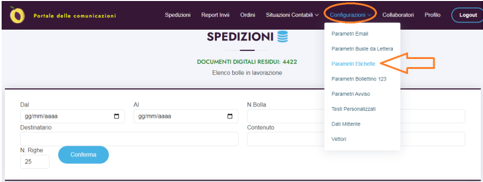
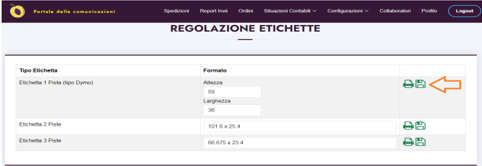
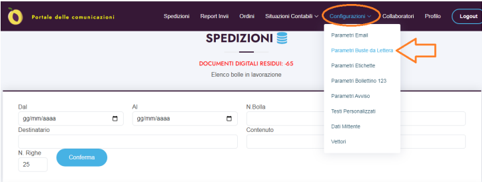
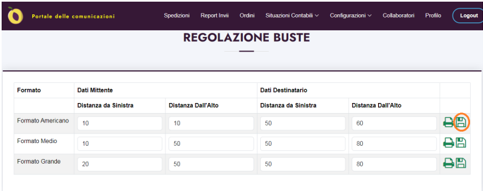

In [136]:
resp.points